<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Ahn_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

# Select bacterial controls
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

# Microarray level Normalization
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preparation

`michigan` dataset contains the measurements, done at University of Michigan lab, of anterior cortex and dorsolateral cortex for each patient. 

`michigan_diff` subtracts measurement of anterior cortex from the dorsolateral cortex for each patient.

In [3]:
# Michigan
michigan = expression_norm[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression_norm[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
#davis

# Irvine
irvine = expression_norm[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]
#irvine_diff

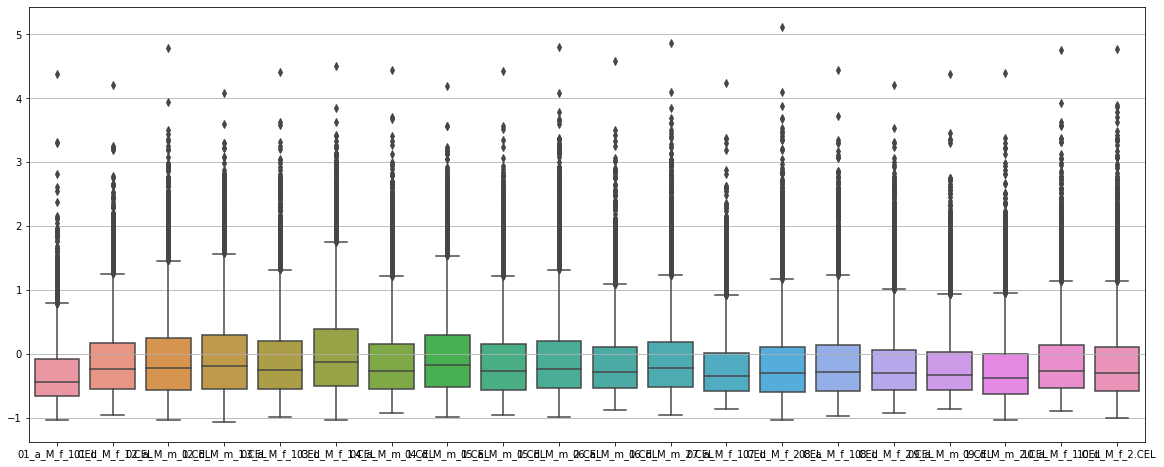

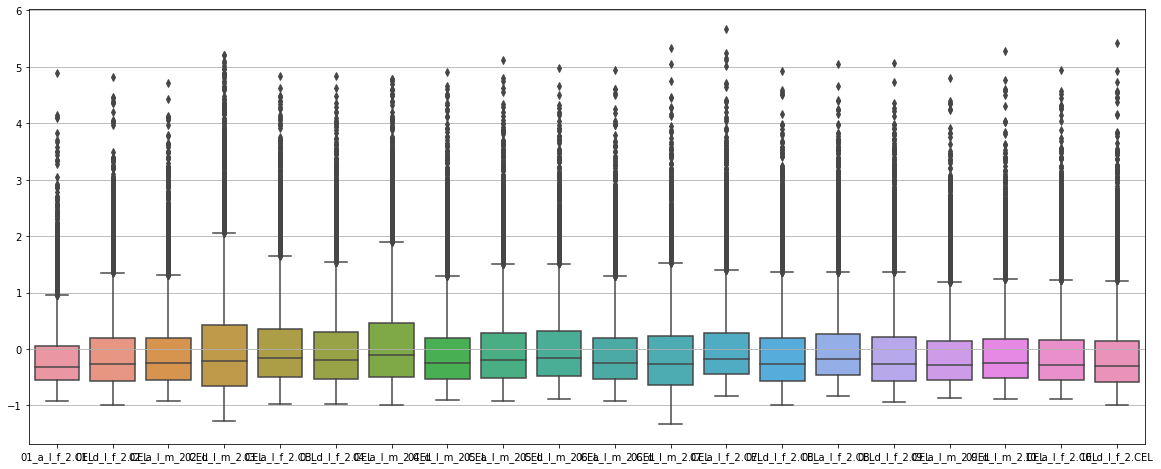

In [4]:
# Microarray-wise distribution: Detected microarray-wise effects for both michigan and irvine
# We ideally want very similar distribution(mean, std) for each microarray. 
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan.T)

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine.T)

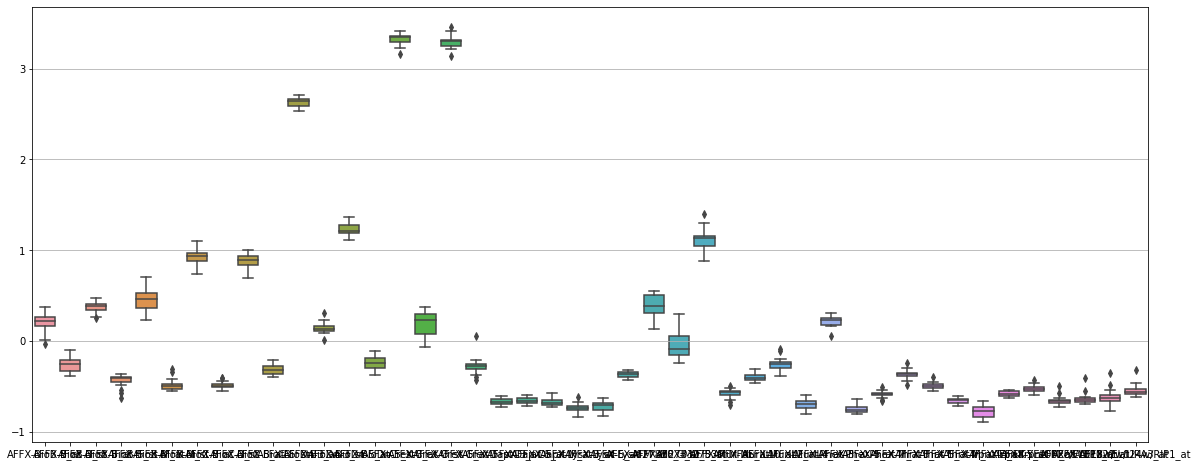

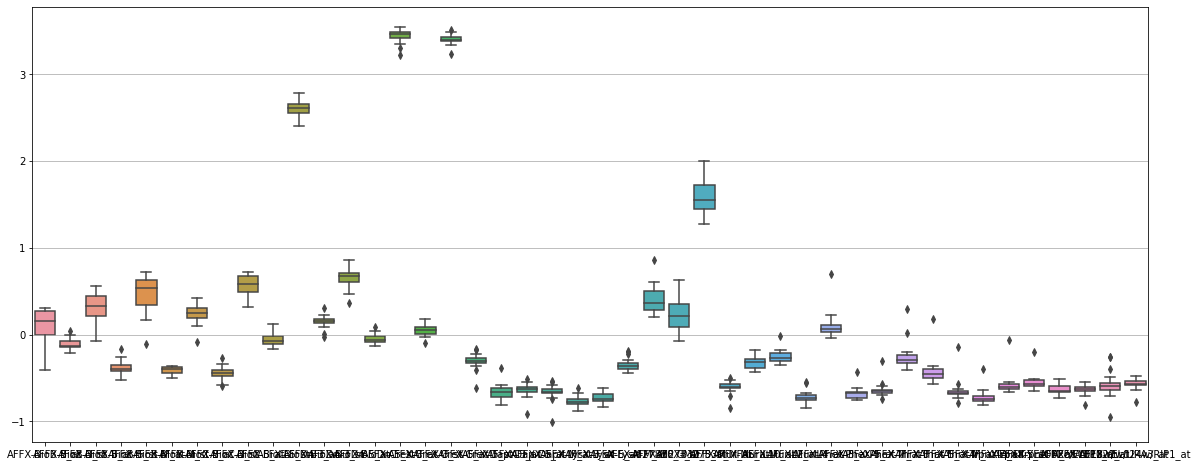

In [6]:
# Plot bacterial controls:
'''
Michigan: has lower expression than Irvine with higher standard deviation
Irvine: 02_d_I_m_2.CEL and 06_d_I_m_2.CEL(3, 11) generally have higher gene expression
We might want to adjust microarray-wise first and then do lab-wise adjustment
'''
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan[genes_bac_index])

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine[genes_bac_index])

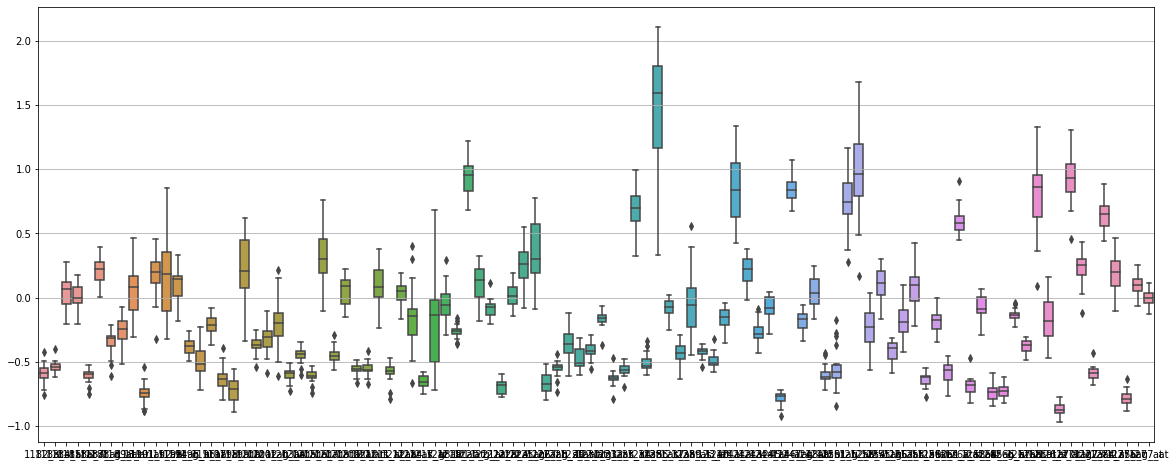

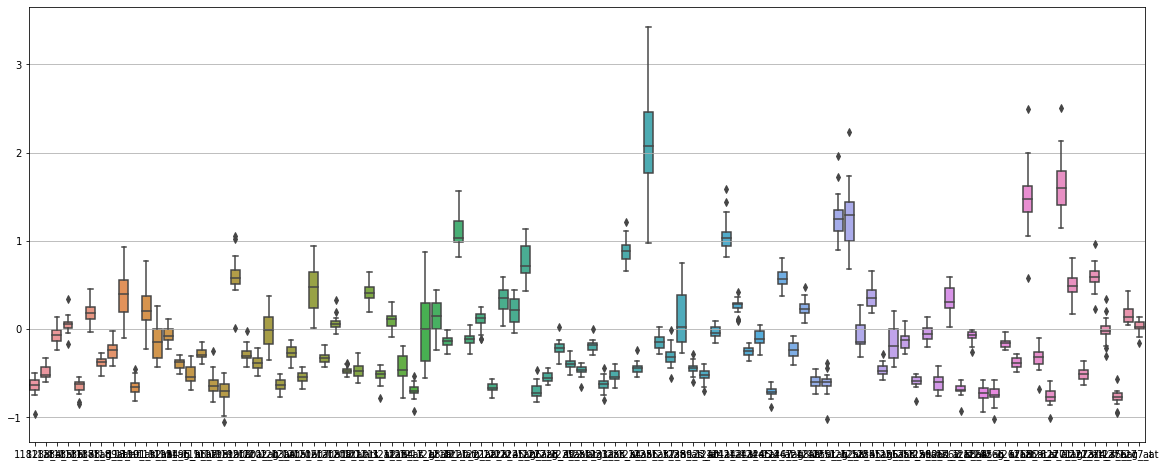

In [7]:
# Plot human genes
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan.iloc[:, 200:300])

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine.iloc[:, 200:300])

# Hypothesis testing 
Wilcoxon signed-rank test/paired t-test for each gene excluding controls
Tests whether the median of the difference is 0/mean of the difference is 0.  
Wilcoxon signed-rank test: A non-parametric alternative test to the paired t-test. 

## Multiple Hypotheses Testing on the actual data

In [8]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def testing(df, lab, mode):
  
  '''
  do Wilcoxon signed-rank test for each gene. 
  Make either Bonferroni or Benjamini-Hochberg correction when doing the multiple testing

  args:
  -----
  df: data frame without the controls
  centered: True/False(T: centered, F: not centered/actual)
  lab: should be one of 'michigan', 'irvine', 'davis'
  mode: 'w' if Wilcoxon-signed-rank test, 't' if paired t-test
  '''

  if (mode=='w'):
    p_val = df.apply(wilcoxon).iloc[1,:]

    print(lab)
    print('Wilcoxon signed-rank test')
    print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))

  else:
    p_val = pd.Series([ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])], index=df.columns)

    print(lab)
    print('Paired t-test')
    print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))

  # single: stores the rejected genes(individual test) at significance level of 0.05
  single = pd.Series([i<0.05 for i in p_val], index=michigan_diff.columns)
  single = single[single ==True]

  # Update p_val: the genes/p-values that were rejected
  p_val = p_val[p_val.index.isin(single.index)]
 
  # Multiple hypothesis testing: BH at 0.01 level
  bonferr = multipletests(p_val, method='bonferroni')[0]
  bh = multipletests(p_val, method='fdr_bh', alpha=0.01)[0] 

  # Storing
  pvals['_'.join([lab, mode])] = p_val
  rejected['_'.join([lab, mode])+'_b'] = bonferr 
  rejected['_'.join([lab, mode])+'_bh'] = bh  

  print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
  print('rejected H0(BH):{} \n'.format(sum(bh)))
  plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label=lab)
  plt.legend()

michigan
Wilcoxon signed-rank test
rejected H0(no correction):5254
rejected H0(bonferroni):0
rejected H0(BH):2193 

irvine
Wilcoxon signed-rank test
rejected H0(no correction):1181
rejected H0(bonferroni):0
rejected H0(BH):0 



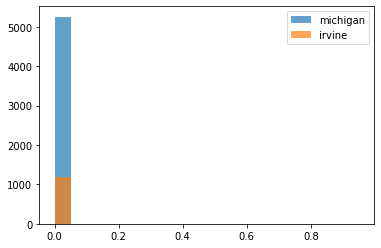

In [9]:
# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Remove controls
michigan_diff = michigan_diff[[c for c in michigan_diff.columns if c not in genes_bac_index]]
irvine_diff = irvine_diff[[c for c in irvine_diff.columns if c not in genes_bac_index]]

testing(michigan_diff, 'michigan', 'w')
testing(irvine_diff, 'irvine', 'w')

michigan
Paired t-test
rejected H0(no correction):5486
rejected H0(bonferroni):126
rejected H0(BH):2585 

irvine
Paired t-test
rejected H0(no correction):1223
rejected H0(bonferroni):1
rejected H0(BH):0 



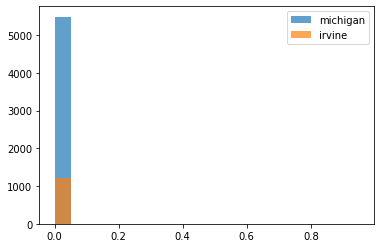

In [10]:
testing(michigan_diff, 'michigan', 't')
testing(irvine_diff, 'irvine', 't')

In [11]:
top20_m = pvals['michigan_t'].sort_values().head(20).index
genes.loc[top20_m]

,sym,chrom
36634_at,BTG2,1
38352_at,PPIH,1
40258_at,CSNK2A1,20
36664_at,GALT,9
40084_at,TFCP2,12
41696_at,GGCT,7
31891_at,CHI3L2,1
39602_at,MYRIP,3
32629_f_at,BTN3A1,6
40266_at,VASH1,14


## Multiple Hypothesis Testing results
The keys are represented as : {lab}_{wilcoxon/t-test}_{bonferroni/B-H}.  
The cotrol centered data gives the results that we expect.

In [ ]:
print('# of rejected H0 using the actual data')
print(pd.DataFrame(rejected).apply(np.sum))

print('# of rejected H0 using the centered data')
print(pd.DataFrame(rejected_c).apply(np.sum))


Do the same procedure on the aggregated (Michigan + Irvine) data

In [ ]:
df = pd.concat([michigan_c_diff, irvine_c_diff])  # Row index not adjusted

# Wilcoxon signed-rank test
p_val = df.apply(wilcoxon).iloc[1,:] 
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]  
print('Wilcoxon signed-rank test')
print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.7, label='Aggregate_W')


# Paired t-test
p_val = [ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])]
bonferr = multipletests(p_val, method='bonferroni')[0]  
bh = multipletests(p_val, method='fdr_bh')[0]   
print('paired t-test')
print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))
print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
print('rejected H0(BH):{} \n'.format(sum(bh)))
plt.hist(p_val, bins=np.arange(0, 1, 0.05), alpha=0.5, label='Aggregate_T')
plt.legend()


# Gene Investigation
Investigate genes(227): centered data from Michigan lab using paired t-test w/ bonferroni correction: michigan_c_t_b 

In [ ]:
g = michigan_c_diff.columns[rejected_c['michigan_c_t_b']]
g_pval = np.array(pvals_c['michigan_c_t'])
g_pval = g_pval[np.array(rejected_c['michigan_c_t_b'])]
genes.loc[g]

In [ ]:
genes.loc[g].groupby('chrom').size().sort_values(ascending=False)